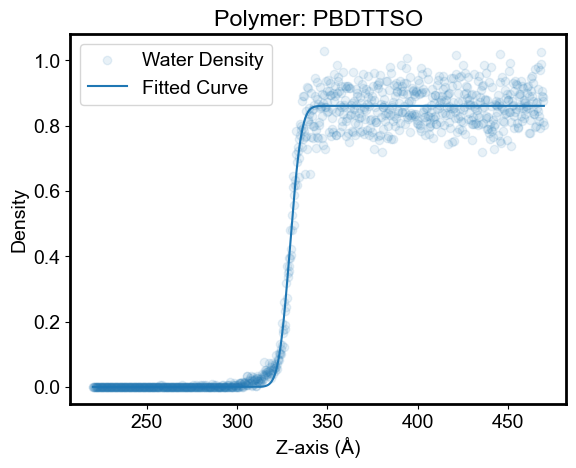

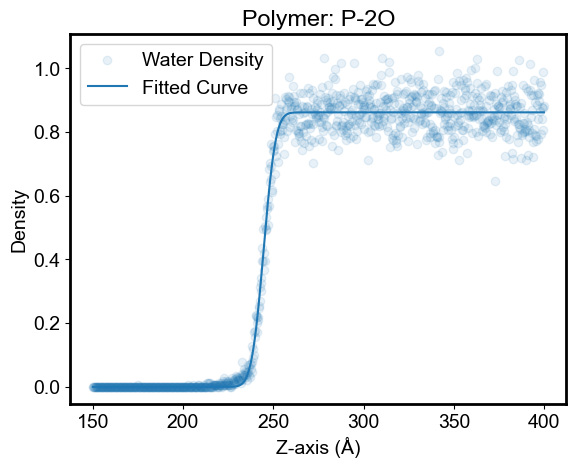

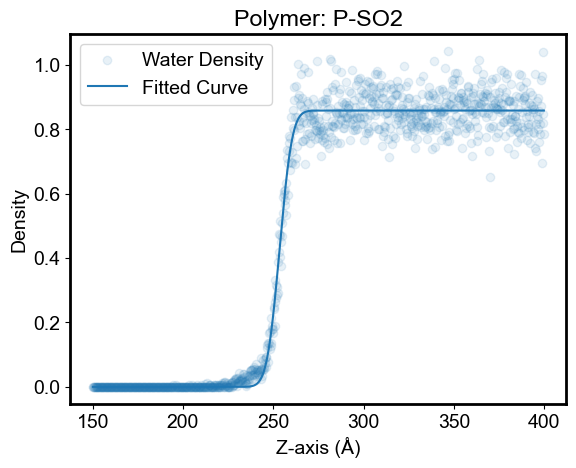

In [2]:
import MDAnalysis as mda
import MDAnalysis.transformations as trans
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import font_manager
from MDAnalysis.analysis import lineardensity as lin
from scipy import special
from scipy.optimize import curve_fit
font_manager.findSystemFonts(fontpaths=None, fontext="ttf")
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['font.size'] = 14
plt.rcParams['font.sans-serif'] = 'Arial'

# calculate density profile of water molecules
def count_density(file):
    u = mda.Universe(f'../solution/{file}/npt_1.tpr', f'../solution/{file}/solution.gro')
    water = u.select_atoms('moltype H2O')
    water_density = lin.LinearDensity(water, grouping='atoms').run()
    z_length = u.dimensions[2]
    z_bins = len(water_density.results['z']['mass_density'])
    z_range = np.linspace(0, z_length, z_bins)
    return z_range, water_density.results['z']['mass_density']

# error function
def error_function(x, A, g, x0):
    return A * 0.5 * (special.erf(g * (x - x0) ) + 1)

# Select the range of density profiles for three types of polymers
range_start = [220,150, 150]
range_end = [i + 250 for i in range_start]
polymers = ["PBDTTSO", "P-2O", "P-SO2" ]

data_store = {}

for i, polymer in enumerate(polymers):
    x, water = count_density(polymer)

    # Select the range of density profiles for error function fitting
    mask = (x >= range_start[i]) & (x <= range_end[i])
    x_fit = x[mask]
    water_fit = water[mask]

    # initial guess of error function fitting
    p0 = [1.0, 0.1, 250.] # A, g, h, x0
    # fitting error function
    popt, _ = curve_fit(error_function, x_fit, water_fit, p0=p0)
    water_err = error_function(x_fit, *popt)

    data_store[polymer] = {
        "x_fit": x_fit,
        "water_fit": water_fit,
        "water_err": water_err,
        "fit_params": popt
    }

    # plot results of density profile
    plt.scatter(x_fit, water_fit, label="Water Density", alpha=0.1)
    plt.plot(x_fit, water_err, label="Fitted Curve")
    plt.xlabel("Z-axis (Å)")
    plt.ylabel("Density")
    plt.title(f"Polymer: {polymer}")
    plt.legend()
    plt.show()    



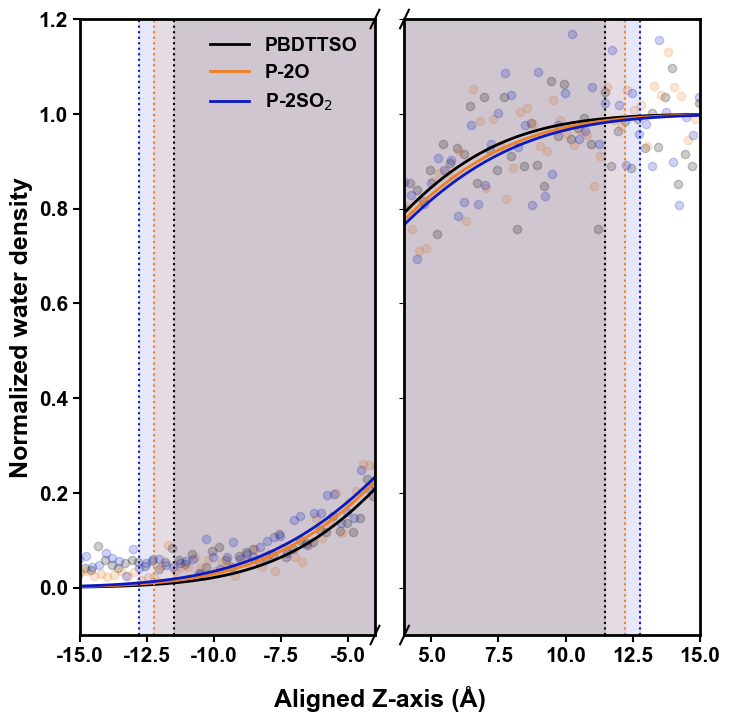

In [3]:
from scipy import optimize
from scipy.optimize import fsolve
aligned_data_store = {}

# calculate interface position
def f(x, *p):
    return p[0] * 0.5 * (special.erf(p[1] * (x - p[2])) + 1) - p[0]*0.01

# initial guess of interface position
p0 = [310, 250, 250]

for n, polymer in enumerate(data_store):
    x_fit = data_store[polymer]["x_fit"]
    aligned_x_fit = x_fit - data_store[polymer]["fit_params"][2]
    aligned_water_fit = data_store[polymer]["water_fit"]
    aligned_water_err = data_store[polymer]["water_err"]
    p = tuple(data_store[polymer]["fit_params"])

    # solving interface position
    root = fsolve(f, x0 = p0[n], args = p)- p[2]
  
    aligned_data_store[polymer] = {
        "aligned_x_fit": aligned_x_fit,
        "aligned_water_fit": aligned_water_fit,
        "aligned_water_err": aligned_water_err,
        "interface95": root,
        "interface5": -root
    }

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(8,8), gridspec_kw={'wspace': 0.10})

xlim1 = [-15, -4]
xlim2 = [4, 15]

color = ["black", "#F07F23", "#0A1AC0"]
name = ["PBDTTSO", "P-2O", r"P-2SO$_2$"]

for i, polymer in enumerate(aligned_data_store):
    aligned_x_fit = aligned_data_store[polymer]["aligned_x_fit"]
    aligned_water_fit = aligned_data_store[polymer]["aligned_water_fit"]
    aligned_water_err = aligned_data_store[polymer]["aligned_water_err"]
    interface95 = aligned_data_store[polymer]["interface95"]
    interface5 = aligned_data_store[polymer]["interface5"]
    # plot left side
    ax1.scatter(aligned_x_fit, aligned_water_fit / data_store[polymer]["fit_params"][0], c=color[i], alpha=0.2)
    ax1.plot(aligned_x_fit, aligned_water_err / data_store[polymer]["fit_params"][0], c=color[i], lw=2, label=name[i])
    ax1.axvline(x=interface95, color=color[i], linestyle=":")
    ax1.axvline(x=interface5, color=color[i], linestyle=":")
    ax1.fill_betweenx([-0.5, 1.5], interface5, interface95, color=color[i], alpha=0.1)
    # plot right side
    ax2.scatter(aligned_x_fit, aligned_water_fit / data_store[polymer]["fit_params"][0], c=color[i], alpha=0.2)
    ax2.plot(aligned_x_fit, aligned_water_err / data_store[polymer]["fit_params"][0], c=color[i], lw=2, label=name[i])
    ax2.axvline(x=interface95, color=color[i], linestyle=":")
    ax2.axvline(x=interface5, color=color[i], linestyle=":")
    ax2.fill_betweenx([-0.5, 1.5], interface5, interface95, color=color[i], alpha=0.1)

ax1.set_xlim(xlim1)
ax2.set_xlim(xlim2)
ax1.set_xticks(np.arange(xlim1[0], xlim1[1] + 1, 2.5))
ax1.set_xticklabels(ax1.get_xticks(), weight= 'bold', fontsize=15)
ax2.set_xticks(np.arange(xlim2[0]+1, xlim2[1] + 1, 2.5))
ax2.set_xticklabels(ax2.get_xticks(), weight= 'bold', fontsize=15)
plt.setp(ax1.get_yticklabels(), fontweight='bold', fontsize=15)
kwargs = dict(transform=ax1.transAxes, color="k", clip_on=False)
d = 0.015
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)
ax1.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)
# Draw a diagonal line to represent ellipsis
kwargs.update(transform=ax2.transAxes)
ax2.plot((-d, +d), (-d, +d), **kwargs)
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)
ax1.tick_params(axis='x', width=1.5, length=5)
ax2.tick_params(axis='x', width=1.5, length=5)
ax1.tick_params(axis='y', width=1.5, length=5)
fig.text(0.5, 0.02, "Aligned Z-axis (Å)", ha="center", fontsize=18, fontweight = 'bold')
ax1.set_ylabel("Normalized water density", fontsize=18, fontweight = 'bold')
font_properties = font_manager.FontProperties(weight='bold')
ax1.legend(loc="upper right", prop=font_properties,frameon=False,fontsize=18)
ax1.set_ylim(-0.1, 1.2)
plt.show()
